# Práctica 4
# Aprendizaje de redes neuronales
Realizado por Andrés puente y Francisco López

In [1]:
from scipy.io import loadmat
import numpy as np
import displayData as dp
import matplotlib.pyplot as plt
import scipy.optimize as opt
import checkNNGradients as check

# Lectura de datos

4


<Figure size 432x288 with 0 Axes>

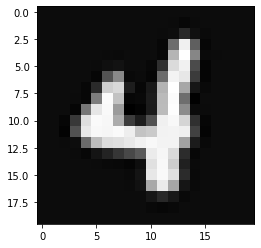

In [2]:
data = loadmat('ex4data1.mat')
Y = data['y']
X = data['X']

nMuestras = len(X)
Y = np.ravel(Y)


print(Y[2222])
plt.figure()
dp.displayImage(X[2222])
plt.savefig("Input_sample")
plt.show()

In [3]:
weights = loadmat('ex4weights.mat')
theta1,theta2 = weights['Theta1'],weights['Theta2']

In [4]:
# SIGMOIDE 
def sigmoide(value):
    return 1/(1+np.exp(-value))
def sigmoideDerivada(value):
    temp = sigmoide(value)
    return temp * (1 - temp)

def pesosAleatorios(L_in,L_out):
    return 0

### Retro-propagacion -> Forward propagation
El algoritmo de retro-propagación nos permite calcular el gradiente de la función de coste de la red neuronal.

Para ello se utilizaran 2 funciones, forwardProp y backprop.

ForwardProp es una funcion de hipotesis que utiliza un valor de entrada para predecir una salida mediante una matriz de pesos. Tambien añadira un termino de sesgo.



In [5]:
def forwardProp(th1, th2, X):
    z1 = th1.dot(X.T)
    a1 = sigmoide(z1)
    tuple = (np.ones(len(a1[0])), a1)
    a1 = np.vstack(tuple)
    z2 = th2.dot(a1)
    a2 = sigmoide(z2)
    return z1, a1, z2, a2

X_aux = np.hstack([np.ones((len(X), 1), dtype = np.float), X])
print("Valor predecido para el elemento 0 de X segun la hipotesis: ", 
      (forwardProp(theta1, theta2, X_aux)[3]).T[0].argmax())

Valor predecido para el elemento 0 de X segun la hipotesis:  9


## Función de coste
La función de coste, se implementara con regularización. Como entrada a dicha función, hemos de preparar un vector de Y distinto al recibido. Será una matriz de (numElementos, numEtiquetas) donde cada fila corresponde a un caso. Cada fila tendrá todos los valores a cero menos el valor real que representa ese caso, que estará a 1.

In [6]:
def costFun(X, y, theta1, theta2, reg):
    #Here we assert that we can operate with the parameters
    X = np.array(X)
    y = np.array(y)
    muestras = len(y)

    theta1 = np.array(theta1)
    theta2 = np.array(theta2)

    hipo  = forwardProp(theta1, theta2, X)[3]
    cost = np.sum((-y.T)*(np.log(hipo)) - (1-y.T)*(np.log(1- hipo)))/muestras

    regcost = np.sum(np.power(theta1[:, 1:], 2)) + np.sum(np.power(theta2[:,1:], 2))
    regcost = regcost * (reg/(2*muestras))

    return cost + regcost

def getYMatrix(Y, nEtiquetas):
    nY = np.zeros((len(Y), nEtiquetas))
    yaux = np.array(Y) -1
    #print(Y)
    #print(len(nY))
    
    for i in range(len(nY)):
        #z = yaux[i].all()
        z = yaux[i]
        if(isinstance(z, np.uint8)):
            if(z == 10): z = 0
            nY[i][z] = 1
        else:
            z = yaux[i].all()
            if(z == 10): z = 0
            nY[i][z] = 1
                
        #print(z)
        #print("Y de ceros: ", nY)
    return nY

In [7]:
Y_aux = getYMatrix(Y, 10)

print("El coste con thetas entrenados es: ", costFun(X_aux, Y_aux, theta1, theta2, 1))

El coste con thetas entrenados es:  0.3837698590909236


### BackPropagation

Backpropagation se usa para repartir el error entre las neuronas de la red neuronal. 
Comienza desde la ultima capa y desde esa desciende hasta la penúltima, ya que no se puede 
repartir error para la capa de entrada.

In [9]:
#Devuelve el coste y el gradiente de una red neuronal de dos capas
def backprop(params_rn, num_entradas,num_ocultas, num_etiquetas, X, Y, reg):
    th1 = np.reshape(params_rn[:num_ocultas *(num_entradas + 1)],(num_ocultas, (num_entradas+1)))
    # theta2 es un array de (num_etiquetas, num_ocultas)
    th2 = np.reshape(params_rn[num_ocultas*(num_entradas + 1): ], (num_etiquetas,(num_ocultas+1)))
    
    X_unos = np.hstack([np.ones((len(X), 1), dtype = np.float), X])
    nMuestras = len(X)
    y = np.zeros((nMuestras, num_etiquetas))
    
    y = y + getYMatrix(Y, num_etiquetas)
    
    coste = costFun(X_unos, y, th1, th2, reg)
    
    #Backpropagation
    
    # Forward propagation para obtener una hipótesis y los valores intermedios
    # de la red neuronal
    z2, a2, z3, a3 = forwardProp(th1, th2, X_unos)
    
    gradW1 = np.zeros(th1.shape)
    gradW2 = np.zeros(th2.shape)
    
    # Coste por capas
    delta3 = np.array(a3 - y.T)
    delta2 = th2.T[1:, :].dot(delta3)*sigmoideDerivada(z2)
    
    # Acumulacion de gradiente
    gradW1 = gradW1 + (delta2.dot(X_unos))
    gradW2 = gradW2 + (delta3.dot(a2.T))
    
    G1 = gradW1/float(nMuestras)
    G2 = gradW2/float(nMuestras)
    
    # suma definitiva
    G1[:, 1: ] = G1[:, 1:] + (float(reg)/float(nMuestras))*th1[:, 1:]
    G2[:, 1: ] = G2[:, 1:] + (float(reg)/float(nMuestras))*th2[:, 1:]
    
    gradients = np.concatenate((G1, G2), axis = None)
    
    return coste, gradients

In [10]:
params = np.concatenate((theta1, theta2), axis = None)
print("Diferencias al comprobar gradientes:\n", check.checkNNGradients(backprop, 1))

Diferencias al comprobar gradientes:
 [ 1.14376897e-10  9.90318938e-14  1.15157606e-11  3.08568171e-11
 -1.16232995e-10  2.46816456e-12 -3.54113544e-11 -1.05037631e-10
 -1.62812763e-10  9.56501545e-12 -7.94193045e-11 -2.39369968e-10
 -6.30041019e-11  3.38154504e-12 -2.14650520e-11 -7.55736723e-11
  4.48127369e-11  9.81270620e-13  2.13239218e-11  5.07995868e-11
  6.21964702e-11  1.66536784e-11  8.51685389e-12  4.28101998e-12
  1.72283854e-11  1.71411774e-11  7.11513071e-11  1.42481027e-11
  7.72014397e-12  9.40297840e-12  1.58183466e-11  2.05401252e-11
  6.97608638e-11  1.15627508e-11  1.89406824e-12  1.83976445e-11
  2.21590801e-11  2.11061169e-11]


### Inicializacion aleatoria de thetas

In [11]:
def InitRandomWeight(L_in, L_out):
    cini = 0.2
    a = np.random.uniform(-cini, cini, size = (L_in, L_out))
    a = np.insert(a, 0, 1, axis = 0)
    return a

# Prueba de la red Neuronal


In [12]:
def NNTest (num_entradas, num_ocultas, num_etiquetas, reg, X, Y, laps):
    t1 = InitRandomWeight(num_entradas, num_ocultas)
    t2 = InitRandomWeight(num_ocultas, num_etiquetas)

    params = np.hstack((np.ravel(t1), np.ravel(t2)))
    out = opt.minimize(fun = backprop, x0 = params, args = (num_entradas, num_ocultas, num_etiquetas, X, Y, reg), method='TNC', jac = True, options = {'maxiter': laps})

    Thetas1 = out.x[:(num_ocultas*(num_entradas+1))].reshape(num_ocultas,(num_entradas+1))
    Thetas2 = out.x[(num_ocultas*(num_entradas+1)):].reshape(num_etiquetas,(num_ocultas+1))

    input = np.hstack([np.ones((len(X), 1), dtype = np.float), X])
    hipo = forwardProp(Thetas1, Thetas2, input)[3]


    Ghipo = (hipo.argmax(axis = 0))+1
    prec = (Ghipo == Y)*1
    
    precision = sum(prec) / len(X)

    print("Program precision: ", precision *100, "%")

In [13]:
NNTest(400, 25, 10, 1, X, Y, 70)

Program precision:  90.53999999999999 %


In [14]:
NNTest(400, 25, 10, 1, X, Y, 200)

Program precision:  99.26 %


In [15]:
NNTest(400, 25, 10, 1, X, Y, 5)

Program precision:  20.96 %
